# Analytical Question
Since, my dataset are related to heart disease so my major concern is about the prediction of Heart disease. I have some analytical questions:
1. Can we predict the severity of heart disease (e.g., mild, moderate, severe) based on patient attributes?
2. Which physiological factors (e.g., age, cholesterol, blood pressure) contribute most to heart disease risk?

At first, lets load the data from the cleaned schema and lets create a features from that.

In [71]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt


In [2]:
host = r'127.0.0.1' 
db = r'MSDS610' 
user = r'postgres' 
pw = r'1234' 
port = r'5433' 
schema = r'cleaned'

In [3]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [4]:
schema = "Cleaned"  
table_name = "HeartDisease"  

sql = f'SELECT * FROM "{schema}"."{table_name}"'

data = pd.read_sql(sql, db_conn, index_col=None)
print(data.head())  

   age  sex  cp trestbps  chol fbs restecg thalach exang  oldpeak slope thal   
0   32    1   1       95     0   0       0     127     0      0.7     1    7  \
1   36    1   4      110     0   0       0     125     1      1.0     2    6   
2   38    0   4      105     0   0       0     166     0      2.8     1    7   
3   38    0   4      110     0   0       0     156     0      0.0     2    3   
4   38    1   3      100     0   0       0     179     0     -1.1     1    7   

   num  
0    1  
1    1  
2    2  
3    1  
4    0  


In [5]:
df = data.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       238 non-null    int64  
 1   sex       238 non-null    int64  
 2   cp        238 non-null    int64  
 3   trestbps  238 non-null    object 
 4   chol      238 non-null    int64  
 5   fbs       238 non-null    object 
 6   restecg   238 non-null    object 
 7   thalach   238 non-null    object 
 8   exang     238 non-null    object 
 9   oldpeak   238 non-null    float64
 10  slope     238 non-null    object 
 11  thal      238 non-null    object 
 12  num       238 non-null    int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 24.3+ KB


Lets do some feature engineering to creat sone new features from our data, and i am creating features from last week. But i will try to use different features at each iteration.

In [7]:
df['trestbps'] = pd.to_numeric(df['trestbps'])
df['thalach'] = pd.to_numeric(df['thalach'])

In [8]:
df["bp_chol_ratio"] = df["trestbps"] / (df["chol"] + 1)
df["heart_rate_reserve"] = 220 - df["age"] - df["thalach"]
df["slope_oldpeak_product"] = df["slope"].astype(float) * df["oldpeak"]
df["stress_impact"] = (df["thalach"] - df["trestbps"]) / (df["oldpeak"] + 1)


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    238 non-null    int64  
 1   sex                    238 non-null    int64  
 2   cp                     238 non-null    int64  
 3   trestbps               238 non-null    int64  
 4   chol                   238 non-null    int64  
 5   fbs                    238 non-null    object 
 6   restecg                238 non-null    object 
 7   thalach                238 non-null    int64  
 8   exang                  238 non-null    object 
 9   oldpeak                238 non-null    float64
 10  slope                  238 non-null    object 
 11  thal                   238 non-null    object 
 12  num                    238 non-null    int64  
 13  bp_chol_ratio          238 non-null    float64
 14  heart_rate_reserve     238 non-null    int64  
 15  slope_

Since, my dataset are quite small but also lets try to devide it into three set i.e training, test and validation set

Also, for this time, i'm not taking feature slope_oldpeak_product and stress_impact

In [73]:
X = df.drop(columns=['num','slope_oldpeak_product','stress_impact'])
y = df['num']

Splitting into three sets: train, test and validation

In [74]:
# Assuming X is your feature matrix and y is your target variable
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp set

# Split temp set into test and validation (50% each)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% test, 15% validation


In [75]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [76]:
y_test_pred = rf_model.predict(X_test)


In [77]:
# Test Set Performance
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'\nTest Accuracy: {test_accuracy:.4f}')




Test Accuracy: 0.7778


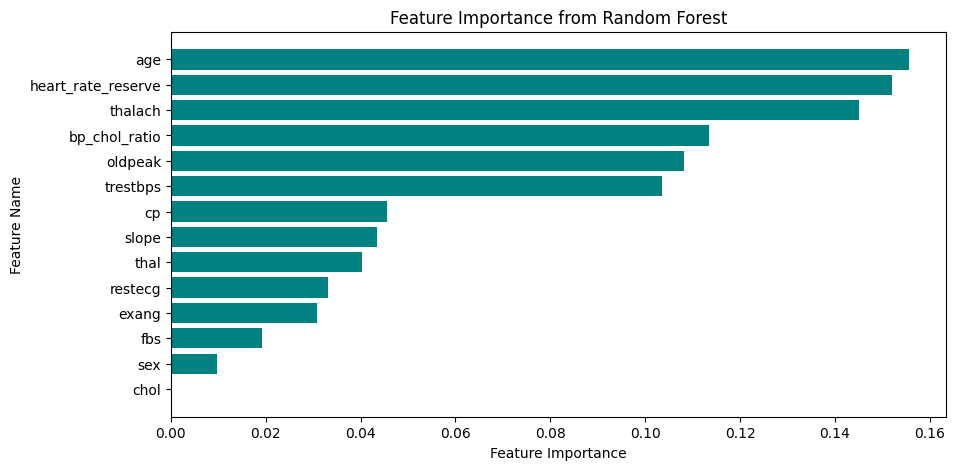

In [78]:
feature_importances = rf_model.feature_importances_

# Create a DataFrame
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
plt.barh(features_df['Feature'], features_df['Importance'], color='teal')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()  # Flip to show the most important feature on top
plt.show()

Accuracy of testing data was less as compared to previous week, maybe dataset is divided into three set or because of the feature choosen. Let, try other feature.

In [79]:
X = df.drop(columns=['num','bp_chol_ratio','heart_rate_reserve'])
y = df['num']

In [80]:
X = pd.get_dummies(X, drop_first=True)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [81]:
# Assuming X is your feature matrix and y is your target variable
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)  # 70% training, 30% temp set
# Split temp set into test and validation (50% each)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% test, 15% validation


In [82]:
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [83]:
y_test_pred = rf_model2.predict(X_test)

In [84]:
# Test Set Performance
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'\nTest Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.7778


Well the accuracy is same for this and previous model, but lets switch features to find more accurate result if possiblr.

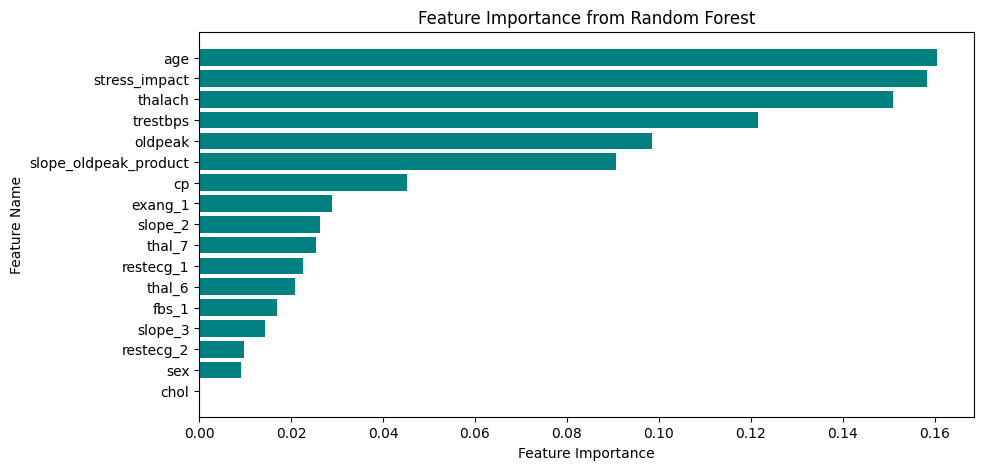

In [86]:
feature_importances = rf_model2.feature_importances_

# Create a DataFrame
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
plt.barh(features_df['Feature'], features_df['Importance'], color='teal')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()  # Flip to show the most important feature on top
plt.show()

Again, lets take two most important features from last week to see if the accuracy will same or not. 
lets take stress_impact and heart_rate reserve

In [87]:
X = df.drop(columns=['num','slope_oldpeak_product','bp_chol_ratio'])
y = df['num']

In [88]:
X = pd.get_dummies(X, drop_first=True)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [89]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp set

# Split temp set into test and validation (50% each)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% test, 15% validation


In [90]:
rf_model3 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model3.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [91]:
y_test_pred = rf_model3.predict(X_test)

# Test Set Performance
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'\nTest Accuracy: {test_accuracy:.4f}')



Test Accuracy: 0.7500


Unexpectedly the accuracy is less this time. Lets take all features once to see difference.

In [92]:
X = df.drop(columns=['num'])
y = df['num']

In [93]:
X = pd.get_dummies(X, drop_first=True)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [94]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp set

# Split temp set into test and validation (50% each)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% test, 15% validation


In [95]:
rf_model4 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model4.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [96]:
y_test_pred = rf_model4.predict(X_test)



# Test Set Performance
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'\nTest Accuracy: {test_accuracy:.4f}')



Test Accuracy: 0.7778


Well the accuracy is same even after taking all the available features. But we can notice, age is one of the important feature.

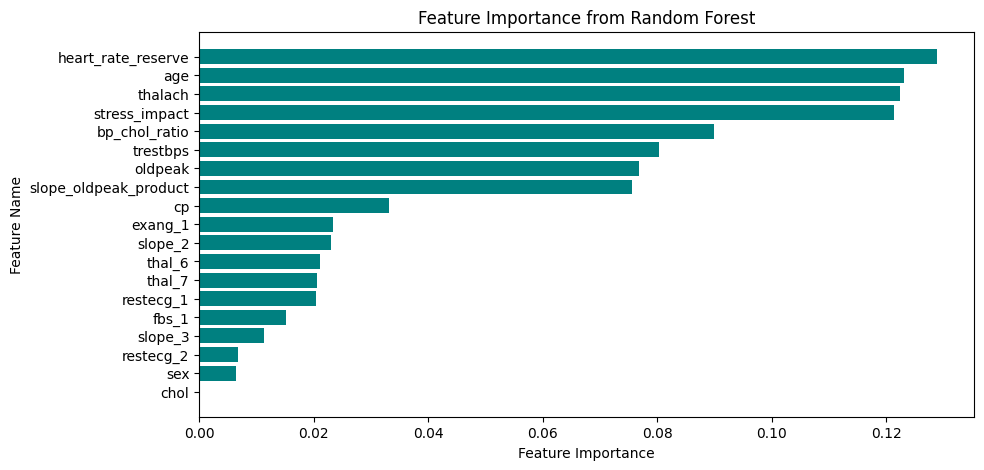

In [98]:
feature_importances = rf_model4.feature_importances_

# Create a DataFrame
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
plt.barh(features_df['Feature'], features_df['Importance'], color='teal')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()  # Flip to show the most important feature on top
plt.show()

In [55]:
selected_features = ["heart_rate_reserve", "age", "thalach", "stress_impact", 
                     "bp_chol_ratio", "trestbps", "oldpeak", "slope_oldpeak_product"]

X_selected = X[selected_features]

In [99]:
X_selected = X_selected.fillna(X_selected.mean())  # Handle missing values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)  # Scale features

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

In [101]:
rf_model5 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model5.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [103]:
test_acc = rf_model5.score(X_test, y_test)


print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7778


I just took 8 important features based on above prediction, but also the result is same and the reson might be the small dataset.

Lets try another algorithm for prediction.

In [104]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

print(f"XGBoost Test Accuracy: {xgb_model.score(X_test, y_test):.4f}")


XGBoost Test Accuracy: 0.7500


In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define optimized RandomForestClassifier
optimized_rf = RandomForestClassifier(
    n_estimators=200,  # Increase estimators for better averaging
    max_depth=20,  # Prevent overly deep trees
    min_samples_split=10,  # Require more samples per split to reduce variance
    min_samples_leaf=5,  # Require more samples per leaf to generalize better
    max_features='sqrt',  # Reduce feature usage per tree to add randomness
    random_state=42
)

# Train the model
optimized_rf.fit(X_train, y_train)

# Predictions
train_preds = optimized_rf.predict(X_train)
test_preds = optimized_rf.predict(X_test)


# Compute accuracy scores
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")




Training Accuracy: 0.8193
Test Accuracy: 0.6944


Even after using another algorithm and trying to optimize the algorithm by tuning hyperparameter also, i am unable to increase accuracy rate. SO, I finalize model that take only 8 important features with accuracy 77.76%.

Now, Lets export the model and validation dataset to validate our model in new notebook.

In [106]:
import joblib

# Save the trained model
joblib.dump(rf_model5, "random_forest_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [117]:

column_names = ["heart_rate_reserve", "age", "thalach", "stress_impact",  
                "bp_chol_ratio", "trestbps", "oldpeak", "slope_oldpeak_product"]
X_val_df = pd.DataFrame(X_val, columns=column_names)  
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)  
y_val_df.columns = ['target']  # Name the column explicitly  

# Reset index of X_val to align with y_val  
X_val_df = X_val_df.reset_index(drop=True)  

# Concatenate features and target  
val_data = pd.concat([X_val_df, y_val_df], axis=1)  

# Save to CSV  
val_data.to_csv("validation_set.csv", index=False)  
print("Validation dataset successfully saved!")  


Validation dataset successfully saved!


So, throughout above process, I tried to enhance accuracy by using different features at different iteration and even tried to optimize model by tuning hyperparameter and even use another algorithm. But the best accuracy was 77.76%. So, I finalize the model that uses 8 important features. Since my dataset was small so I split the dataset as follow:
Training 70%, Test 15%, Validation 15%.